# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
!pip install boruta


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, roc_curve

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [4]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━

In [4]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [5]:
# Converter a coluna de referência temporal para datetime (caso ainda não esteja)
df["data_ref"] = pd.to_datetime(df["data_ref"])

# Identificar os três últimos meses disponíveis na base
ultimos_meses = df["data_ref"].sort_values().unique()[-3:]

# Criar a amostra OOT
df_oot = df[df["data_ref"].isin(ultimos_meses)]

# Criar a amostra de treino (excluindo os três últimos meses)
df_treino = df[~df["data_ref"].isin(ultimos_meses)]

# Definir as variáveis explicativas (excluindo data_ref e index)
variaveis_explicativas = df.columns.difference(["data_ref", "index"])

# Exibir o tamanho das amostras
print(f"Tamanho da amostra de treino: {df_treino.shape}")
print(f"Tamanho da amostra OOT: {df_oot.shape}")

Tamanho da amostra de treino: (600000, 15)
Tamanho da amostra OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
# Número total de linhas
total_linhas = df.shape[0]
print(f"Número total de linhas: {total_linhas}")

# Número de linhas por mês em data_ref
linhas_por_mes = df["data_ref"].value_counts().sort_index()
print("\nNúmero de linhas por mês em data_ref:")
print(linhas_por_mes)

# Separar variáveis qualitativas e quantitativas
variaveis_qualitativas = df.select_dtypes(include=["object", "category"]).columns
variaveis_quantitativas = df.select_dtypes(include=["number"]).columns

# Estatísticas para variáveis quantitativas
print("\nDescritiva das variáveis quantitativas:")
print(df[variaveis_quantitativas].describe())

# Distribuição das variáveis qualitativas
print("\nDescritiva das variáveis qualitativas:")
for coluna in variaveis_qualitativas:
    print(f"\nDistribuição da variável {coluna}:")
    print(df[coluna].value_counts())

Número total de linhas: 750000

Número de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Descritiva das variáveis quantitativas:
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
ma

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

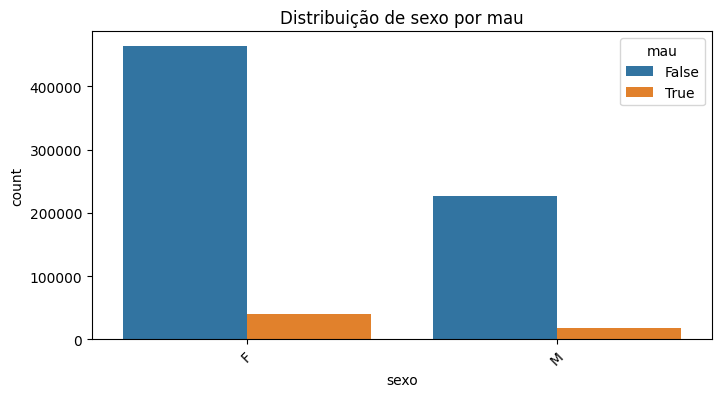

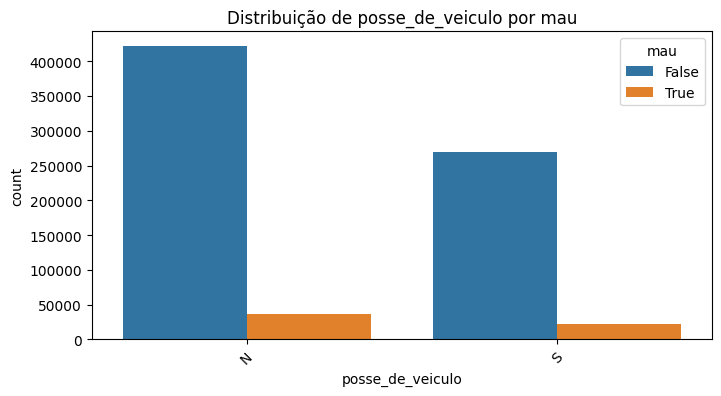

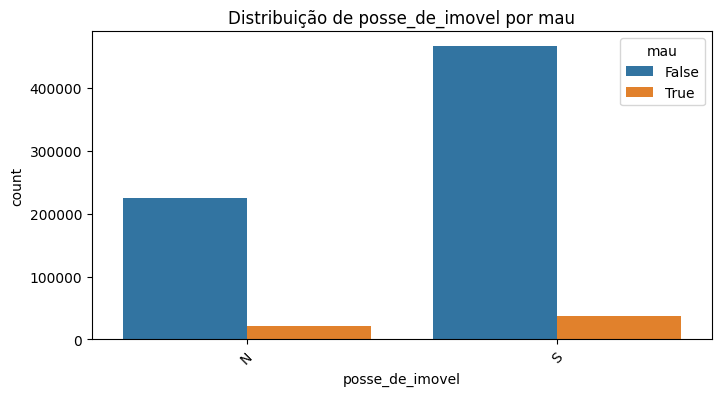

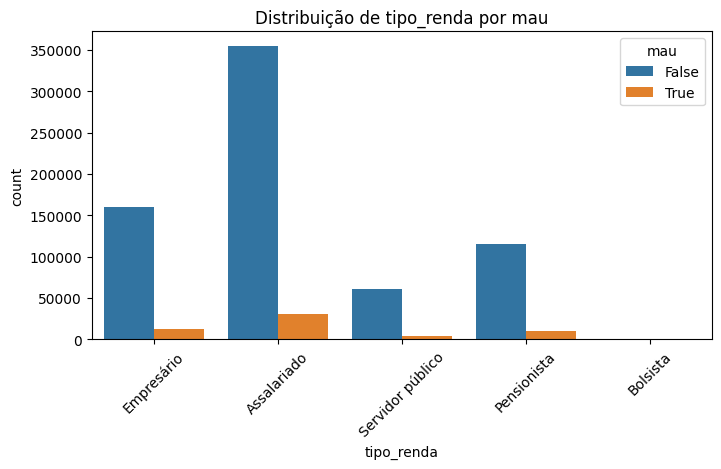

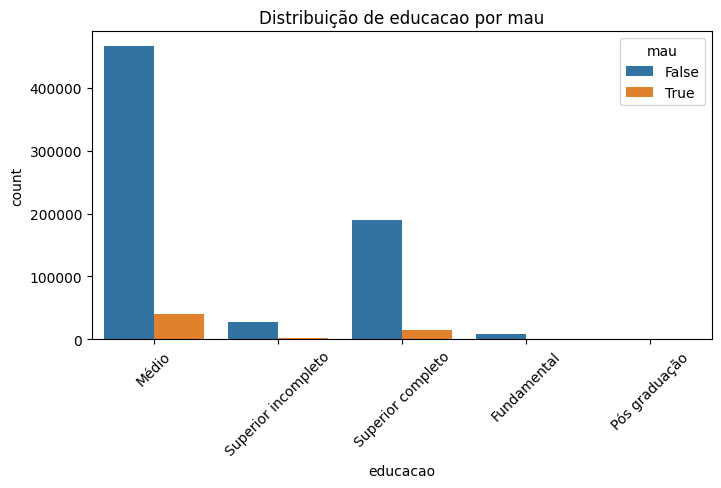

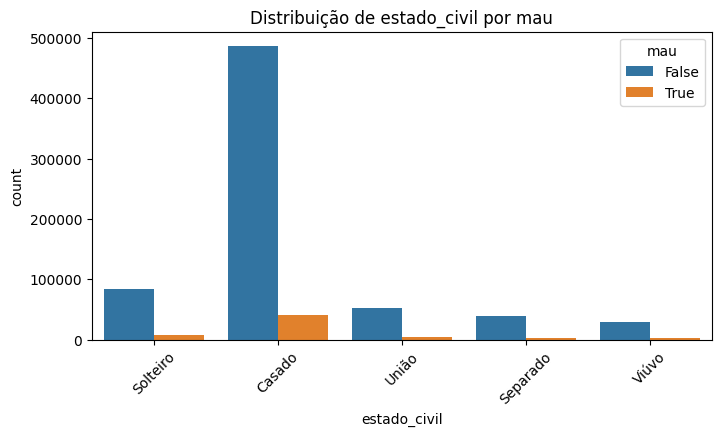

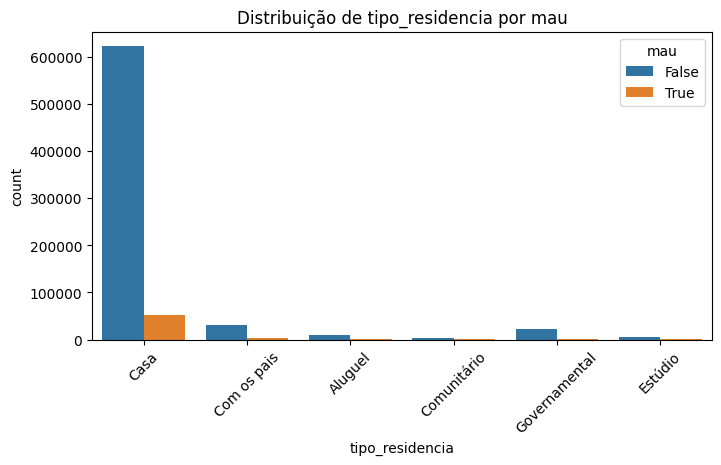

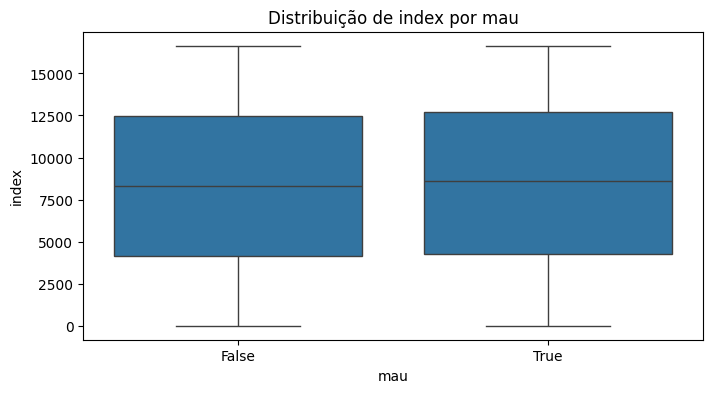

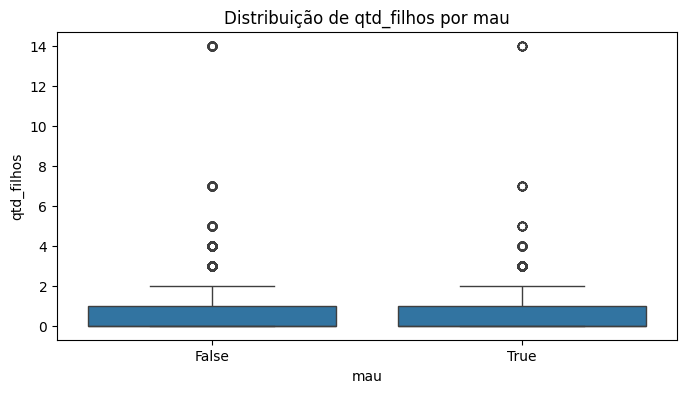

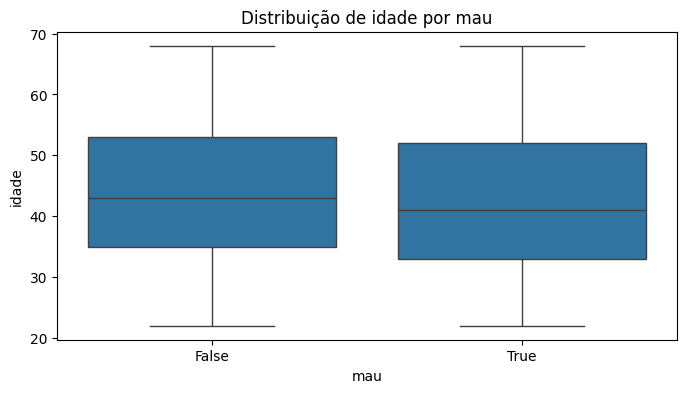

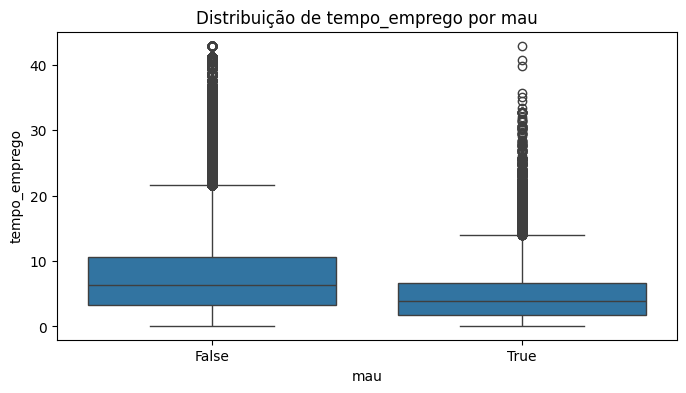

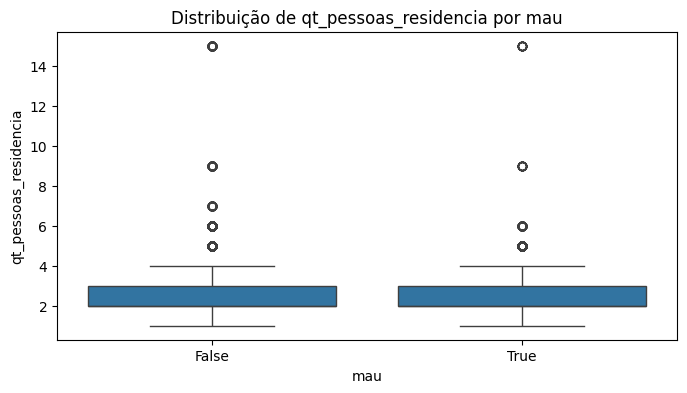

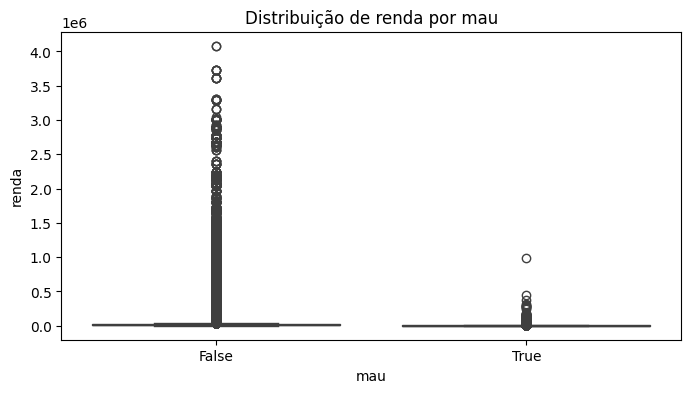

In [7]:
# Criar boxplots para variáveis qualitativas

for coluna in variaveis_qualitativas:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=coluna, hue="mau")
    plt.title(f"Distribuição de {coluna} por mau")
    plt.xticks(rotation=45)
    plt.show()

# Criar boxplots para variáveis quantitativas
for coluna in variaveis_quantitativas:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='mau', y=coluna)
    plt.title(f"Distribuição de {coluna} por mau")
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
# Tratar valores ausentes
df = df.fillna(df.median(numeric_only=True))  # Preenche numéricos com a mediana
df = df.fillna(df.mode().iloc[0])  # Preenche categóricos com a moda

# Tratar outliers usando IQR
for coluna in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])

# Tratar 'zeros estruturais' (exemplo: tempo_emprego)
df['tempo_emprego'] = df['tempo_emprego'].replace(0, df['tempo_emprego'].median())

# Agrupar categorias com baixa frequência
categorias_ajustadas = ["tipo_renda", "educacao", "estado_civil", "tipo_residencia"]
for coluna in categorias_ajustadas:
    frequencias = df[coluna].value_counts(normalize=True)
    categorias_menores = frequencias[frequencias < 0.05].index  # Menos de 5% da amostra
    df[coluna] = df[coluna].replace(categorias_menores, "Outros")

# Separar variáveis preditoras e target
X = df.drop(columns=["data_ref", "index", "mau"])
y = df["mau"]

# One-Hot Encoding para variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# Padronizar variáveis numéricas
scaler = StandardScaler()
X[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X.select_dtypes(include=[np.number]))

# Separar dados em treino e teste (70% treino, 30% teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Treinar modelo de regressão logística
modelo = LogisticRegression()
modelo.fit(X_treino, y_treino)

# Avaliação do modelo
y_pred = modelo.predict(X_teste)
print(classification_report(y_teste, y_pred, zero_division=0))
print(f"AUC-ROC: {roc_auc_score(y_teste, modelo.predict_proba(X_teste)[:, 1])}")

              precision    recall  f1-score   support

       False       0.92      1.00      0.96    207407
        True       0.00      0.00      0.00     17593

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000

AUC-ROC: 0.7785075815068767


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [9]:
# Função para calcular o KS
def ks_score(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    return max(tpr - fpr)

# Função para calcular o Gini
def gini_score(y_true, y_pred_prob):
    return 2 * roc_auc_score(y_true, y_pred_prob) - 1

# Previsões para treino e teste
y_pred_treino = modelo.predict(X_treino)
y_prob_treino = modelo.predict_proba(X_treino)[:, 1]

y_pred_teste = modelo.predict(X_teste)
y_prob_teste = modelo.predict_proba(X_teste)[:, 1]

# Avaliação nas bases de treino e teste
print("=== Avaliação no Treino ===")
print(f"Acurácia: {accuracy_score(y_treino, y_pred_treino):.4f}")
print(f"KS: {ks_score(y_treino, y_prob_treino):.4f}")
print(f"Gini: {gini_score(y_treino, y_prob_treino):.4f}")

print("\n=== Avaliação no Teste ===")
print(f"Acurácia: {accuracy_score(y_teste, y_pred_teste):.4f}")
print(f"KS: {ks_score(y_teste, y_prob_teste):.4f}")
print(f"Gini: {gini_score(y_teste, y_prob_teste):.4f}")

# Avaliação na Base Out of Time (OOT)
df_oot = df[df["data_ref"].isin(sorted(df["data_ref"].unique())[-3:])].copy()  # Últimos 3 meses
X_oot = df_oot.drop(columns=["data_ref", "index", "mau"])
y_oot = df_oot["mau"]

# Aplicar transformações (one-hot encoding e padronização)
X_oot = pd.get_dummies(X_oot, drop_first=True)
X_oot[X_oot.select_dtypes(include=[np.number]).columns] = scaler.transform(X_oot.select_dtypes(include=[np.number]))

y_pred_oot = modelo.predict(X_oot)
y_prob_oot = modelo.predict_proba(X_oot)[:, 1]

print("\n=== Avaliação Out of Time (OOT) ===")
print(f"Acurácia: {accuracy_score(y_oot, y_pred_oot):.4f}")
print(f"KS: {ks_score(y_oot, y_prob_oot):.4f}")
print(f"Gini: {gini_score(y_oot, y_prob_oot):.4f}")


=== Avaliação no Treino ===
Acurácia: 0.9218
KS: 0.4170
Gini: 0.5560

=== Avaliação no Teste ===
Acurácia: 0.9218
KS: 0.4180
Gini: 0.5570

=== Avaliação Out of Time (OOT) ===
Acurácia: 0.8533
KS: 0.3367
Gini: 0.4593


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

In [10]:
# Tratar valores ausentes
df = df.fillna(df.median(numeric_only=True))  # Numéricos com a mediana
df = df.fillna(df.mode().iloc[0])  # Categóricos com a moda

# Tratar outliers usando IQR
for coluna in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[coluna] = np.clip(df[coluna], limite_inferior, limite_superior)

# Tratar 'zeros estruturais'
df['tempo_emprego'] = df['tempo_emprego'].replace(0, df['tempo_emprego'].median())

# Agrupar categorias de baixa frequência
categorias_ajustadas = ["tipo_renda", "educacao", "estado_civil", "tipo_residencia"]
for coluna in categorias_ajustadas:
    frequencias = df[coluna].value_counts(normalize=True)
    categorias_menores = frequencias[frequencias < 0.05].index
    df[coluna] = df[coluna].replace(categorias_menores, "Outros")

# Separar variáveis preditoras e target
X = df.drop(columns=["data_ref", "index", "mau"])
y = df["mau"]

# Identificar variáveis numéricas e categóricas
variaveis_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
variaveis_categoricas = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Criar Pipeline de Pré-processamento
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), variaveis_numericas),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), variaveis_categoricas)
])

# Separar dados em treino e teste (70% treino, 30% teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Criar Pipeline com SMOTE
modelo_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),  # Agora está corretamente posicionado
    ("modelo", LogisticRegression(class_weight="balanced", max_iter=500))
])

# Treinar Modelo
modelo_pipeline.fit(X_treino, y_treino)

# Avaliação do Modelo
y_pred = modelo_pipeline.predict(X_teste)

print(classification_report(y_teste, y_pred, zero_division=0))
print(f"AUC-ROC: {roc_auc_score(y_teste, modelo_pipeline.predict_proba(X_teste)[:, 1])}")

              precision    recall  f1-score   support

       False       0.98      0.55      0.71    207407
        True       0.14      0.84      0.24     17593

    accuracy                           0.58    225000
   macro avg       0.56      0.70      0.47    225000
weighted avg       0.91      0.58      0.67    225000

AUC-ROC: 0.7784261739385842


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

#### <font color=pink> Verificamos que não há valores nulos na base, pois a saída do DataFrame mostra que nenhuma das colunas tinha valores ausentes.

Código usado para verificar nulos:</font>

In [11]:
df.isnull().sum().to_frame(name="Qtd Nulos").assign(Pct_Nulos=lambda x: x["Qtd Nulos"] / len(df) * 100)


,Qtd Nulos,Pct_Nulos
data_ref,0,0.0
index,0,0.0
sexo,0,0.0
posse_de_veiculo,0,0.0
posse_de_imovel,0,0.0
qtd_filhos,0,0.0
tipo_renda,0,0.0
educacao,0,0.0
estado_civil,0,0.0
tipo_residencia,0,0.0


#### <font color=pink>Se houvesse nulos, deveríamos tratá-los da seguinte maneira:

#### <font color=pink>Dados numéricos: Pode-se substituir pela média ou mediana.

#### <font color=pink>Dados categóricos: Pode-se substituir pelo valor mais frequente (moda).

Exemplo de código para tratamento:</font>

In [12]:
# Substituir nulos em numéricos com a mediana
df.fillna(df.median(numeric_only=True), inplace=True)

# Substituir nulos em categóricos com a moda
for coluna in df.select_dtypes(include=["object"]).columns:
    df[coluna].fillna(df[coluna].mode()[0], inplace=True)

print(df.isnull().sum())

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

#### <font color=pink>Para identificar outliers utilizamos o método do Intervalo Interquartil (IQR). Valores que estão abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR são considerados outliers.

#### <font color=pink>Outra opção é utilizar o z-score, considerando valores acima de 3 desvios padrão como outliers.</font>

Código para identificar outliers com IQR:</font>

In [13]:
# Selecionar apenas colunas numéricas
df_numerico = df.select_dtypes(include=[np.number])

# Calcular quartis e IQR corretamente
Q1 = df_numerico.quantile(0.25)
Q3 = df_numerico.quantile(0.75)
IQR = Q3 - Q1

# Encontrar outliers
outliers = ((df_numerico < (Q1 - 1.5 * IQR)) | (df_numerico > (Q3 + 1.5 * IQR)))

# Mostrar a quantidade de outliers por variável
print(outliers.sum())

index                    0
qtd_filhos               0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


#### <font color=pink>Para substituir ou remover outliers, devemos verificar algumas coisas:

* #### <font color=pink>Se forem valores extremos que podem distorcer a análise, podemos substituí-los.

* #### <font color=pink>Se forem erros ou não fizerem sentido no contexto do problema, podemos remover a linha inteira.

<font color=pink>Opção 1: Substituir outliers pelo limite superior/inferior (Winsorization)</font>

In [14]:
for coluna in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])

    print(f"Coluna: {coluna}")
    print(f"Q1: {Q1}")
    print(f"Q3: {Q3}")
    print(f"IQR: {IQR}")

Coluna: index
Q1: 4147.0
Q3: 12487.0
IQR: 8340.0
Coluna: qtd_filhos
Q1: 0.0
Q3: 1.0
IQR: 1.0
Coluna: idade
Q1: 34.0
Q3: 53.0
IQR: 19.0
Coluna: tempo_emprego
Q1: 3.635616438356165
Q3: 9.09041095890411
IQR: 5.454794520547946
Coluna: qt_pessoas_residencia
Q1: 2.0
Q3: 3.0
IQR: 1.0
Coluna: renda
Q1: 3467.7
Q3: 18318.28
IQR: 14850.579999999998


<font color=pink>Opção 2: Remover as linhas com outliers</font>

<font color=pink>Essa abordagem remove todas as linhas onde pelo menos uma variável tem um outlier.</font>

In [15]:
# Aplicar remoção de outliers apenas nas colunas numéricas
df_numerico = df.select_dtypes(include=[np.number])

# Criar uma máscara para os outliers
outliers = ((df_numerico < (Q1 - 1.5 * IQR)) | (df_numerico > (Q3 + 1.5 * IQR)))

# Remover outliers apenas das colunas numéricas, mantendo as demais colunas
df_sem_outliers = df[~outliers.any(axis=1)]

print(df_sem_outliers.shape)

(750000, 15)


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

#### <font color=pink>A seleção de variáveis é essencial para melhorar o desempenho do modelo, reduzir overfitting e aumentar interpretabilidade. Algumas técnicas comuns são:

#### <font color=pink>1- Boruta

* #### <font color=pink>Baseada em algoritmos de árvores (como Random Forest), a técnica Boruta adiciona versões aleatórias das variáveis originais (shadow features) e seleciona apenas as que realmente possuem importância.

* #### <font color=pink>Ideal para identificar variáveis realmente úteis, eliminando as irrelevantes.</font>

<font color=pink>Código exemplo:</font>

In [16]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [17]:
X_treino = pd.get_dummies(X_treino, drop_first=True)
X_teste = pd.get_dummies(X_teste, drop_first=True)

# Alinha colunas das duas bases (em caso de categorias diferentes entre treino e teste)
X_treino, X_teste = X_treino.align(X_teste, join='left', axis=1, fill_value=0)

# Criando o modelo base para o Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", random_state=42)

# Inicializando o Boruta
boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)

# Aplicando o Boruta
boruta.fit(X_treino.values, y_treino.values)

# Selecionando as variáveis importantes
variaveis_selecionadas = X_treino.columns[boruta.support_].tolist()
print("Variáveis selecionadas:", variaveis_selecionadas)

# Mantendo apenas as variáveis escolhidas
X_treino = X_treino[variaveis_selecionadas]
X_teste = X_teste[variaveis_selecionadas]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	17
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	17
I

#### <font color=pink>2- Feature Importance (Importância dos Atributos)

* #### <font color=pink>Utiliza modelos como Random Forest ou XGBoost para avaliar a relevância das variáveis.

<font color=pink>Código exemplo usando Random Forest:</font>

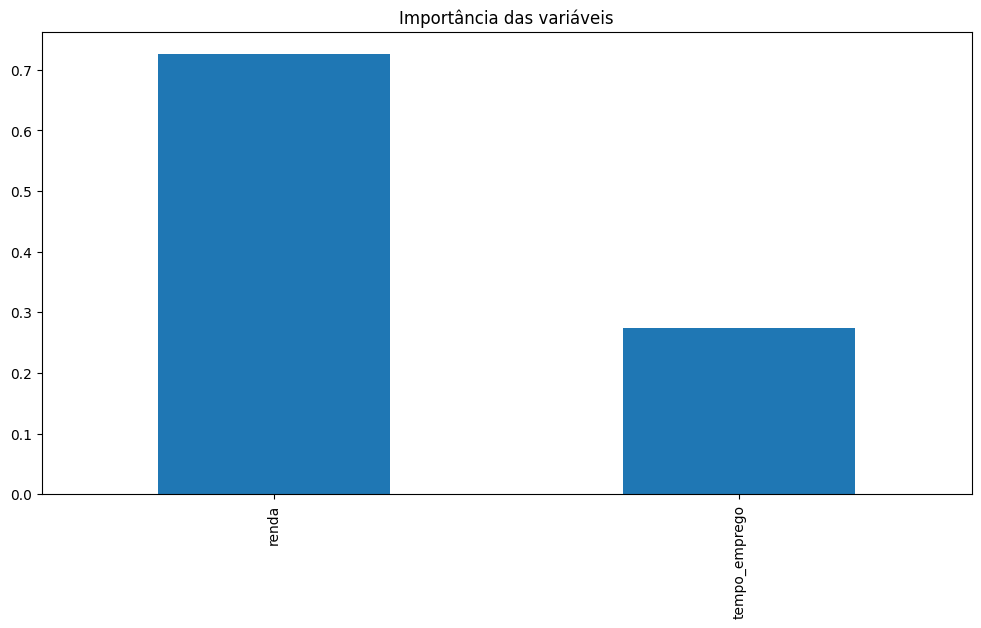

In [18]:
# Treinando um modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_treino, y_treino)

# Obtendo a importância das variáveis
importances = pd.Series(rf.feature_importances_, index=X_treino.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Importância das variáveis")
plt.show()

* <font color=pink>Se quisermos uma seleção mais rigorosa e automática → Boruta

* <font color=pink>Se quisermos apenas um ranking para remover variáveis irrelevantes → Feature Importance</font>

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [19]:
from sklearn.decomposition import PCA

In [20]:
# Normalizar os dados
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste)

# Ajustar o número de componentes principais para ser menor ou igual ao número de features
n_components = min(5, X_treino_scaled.shape[1])  # Escolher o mínimo entre 5 e o número de features
pca = PCA(n_components=n_components)

# Aplicar PCA
X_treino_pca = pca.fit_transform(X_treino_scaled)
X_teste_pca = pca.transform(X_teste_scaled)

# Verificar a variância explicada por cada componente
print(f"Variância explicada pelos {n_components} componentes: {pca.explained_variance_ratio_}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.2%}")

Variância explicada pelos 2 componentes: [0.7940324 0.2059676]
Variância total explicada: 100.00%


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [21]:
variaveis_cat = [
    "sexo",
    "posse_de_veiculo",
    "posse_de_imovel",
    "tipo_renda",
    "educacao",
    "estado_civil",
    "tipo_residencia"
]

# Criação dos dummies, removendo a primeira categoria para evitar multicolinearidade
df_dummies = pd.get_dummies(df, columns=variaveis_cat, drop_first=True)

print(df_dummies.head())


    data_ref   index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0 2015-01-01  5733.0         0.0   43.0       6.873973                    1.0   
1 2015-01-01   727.0         0.0   35.0       4.526027                    2.0   
2 2015-01-01  6374.0         2.0   31.0       0.243836                    4.0   
3 2015-01-01  9566.0         0.0   54.0      12.772603                    2.0   
4 2015-01-01  9502.0         0.0   31.0       8.432877                    1.0   

      renda    mau  sexo_M  posse_de_veiculo_S  ...  tipo_renda_Outros  \
0   2515.39  False   False               False  ...              False   
1   3180.19  False   False                True  ...              False   
2   1582.29  False   False               False  ...              False   
3  13721.17  False   False               False  ...              False   
4   2891.08  False   False                True  ...              False   

   tipo_renda_Pensionista  tipo_renda_Servidor público  educacao_Out

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [22]:
def preprocessamento(df):
    # Separar colunas numéricas e categóricas
    col_num = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    col_cat = ["posse_de_veiculo"]  # só vamos tratar essa como dummy aqui

    # Transformador para colunas numéricas
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5))
    ])

    # Transformador para colunas categóricas (dummies)
    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", sparse_output=False))
    ])


    # Juntando numérico + categórico
    preprocessor = ColumnTransformer([
        ("num", num_pipeline, col_num),
        ("cat", cat_pipeline, col_cat)
    ])

    # Aplicar o pipeline ao DataFrame
    df_preprocessado = preprocessor.fit_transform(df)

    # Retornar como DataFrame
    colunas_numericas_pca = [f"PCA_{i+1}" for i in range(5)]
    colunas_categoricas = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(col_cat)
    colunas_finais = colunas_numericas_pca + list(colunas_categoricas)

    return pd.DataFrame(df_preprocessado, columns=colunas_finais)

df_transformado = preprocessamento(df)
display(df_transformado.head())

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,posse_de_veiculo_S
0,-1.095132,-0.959582,0.488238,-0.493435,-0.632761,0.0
1,-0.067795,-1.027913,1.569849,-0.843420,-0.283412,1.0
2,3.526445,-0.767368,0.674939,0.408831,0.417313,0.0
3,-1.112750,0.762543,-0.319081,0.547662,-0.769332,0.0
4,-0.645179,-0.820062,-0.341089,-1.406264,-0.984909,1.0


# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [23]:
from pycaret.classification import *

In [24]:
df_pycaret = df.copy()

# Setup sem o argumento 'silent'
exp = setup(
    data=df,
    target='mau',
    session_id=42,
    imputation_type='simple',
    numeric_imputation='mean',
    categorical_imputation='mode',
    normalize=True,
    normalize_method='zscore',
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel',
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ],
    verbose=True  # Pode deixar True para ver os detalhes
)


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 27)"
5,Transformed train set shape,"(525000, 27)"
6,Transformed test set shape,"(225000, 27)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9225,0.7788,0.0285,0.5850,0.0544,0.0474,0.1167
1,0.9222,0.7812,0.0256,0.5615,0.0489,0.0424,0.1076
2,0.9224,0.7823,0.0251,0.5886,0.0481,0.0420,0.1099
3,0.9226,0.7887,0.0314,0.5972,0.0597,0.0523,0.1243
4,0.9222,0.7791,0.0295,0.5402,0.0559,0.0482,0.1126
5,0.9221,0.7817,0.0278,0.5403,0.0528,0.0455,0.1093
6,0.9223,0.7773,0.0263,0.5654,0.0503,0.0436,0.1097
7,0.9220,0.7795,0.0251,0.5228,0.0479,0.0410,0.1016
8,0.9222,0.7815,0.0258,0.5464,0.0493,0.0426,0.1062


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9222,0.7812,0.0282,0.5427,0.0536,0.0462,0.1105


Transformation Pipeline and Model Successfully Saved


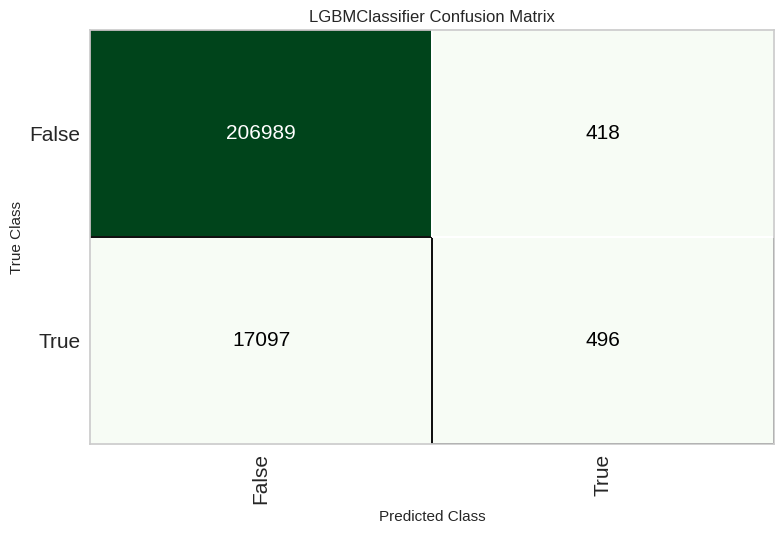

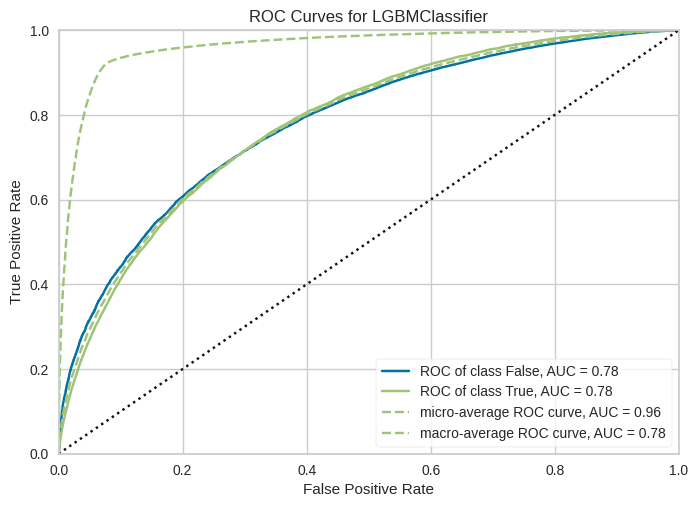

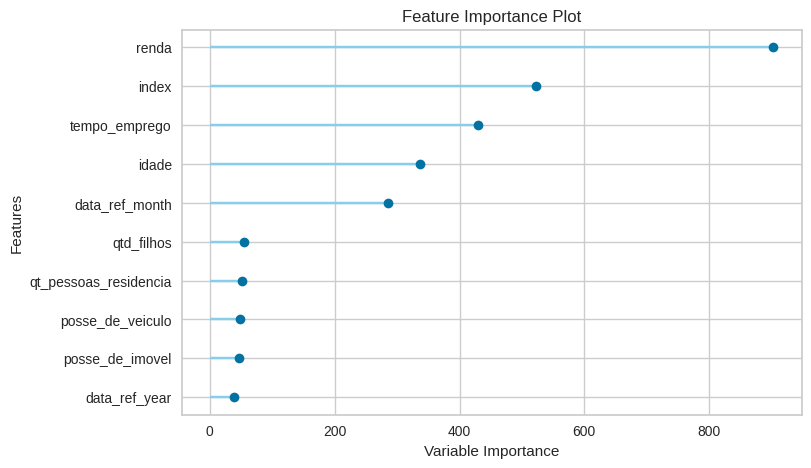

In [27]:
# Criar o modelo LightGBM
lightgbm_model = create_model('lightgbm')

# Avaliar o modelo com gráficos interativos
evaluate_model(lightgbm_model)

# Gerar previsões
predictions = predict_model(lightgbm_model)

# Salvar o pipeline completo com o modelo e transformações
save_model(lightgbm_model, 'modelo_lightgbm_pycaret')

# Gráficos de Avaliação
# Use lightgbm_model for plotting instead of 'modelo'
plot_model(lightgbm_model, plot='confusion_matrix')
plot_model(lightgbm_model, plot='auc')
plot_model(lightgbm_model, plot='feature')